# IMRT QA second model

In [309]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

## Cleaning data
Here I manually changed a few measurement that were baddly typed. I filled NAs in a couple of columns and I get rid of NAs in the outcome variable.

In [666]:
path = "/data2/yinterian/IMRT-2/"

In [667]:
df = pd.read_csv(path + "Numeric_data-clean.csv")

In [668]:
df.describe()

,Machine-Type,Technique,NumberOfFields,Energy,NumberOfDetectors,SBRTplan,GlobalPassingRate,LocalPassingRates,tmp,red,output
count,797.000000,797.000000,797.000000,797.000000,795.000000,794.000000,795.000000,792.000000,0.0,0.0,0.0
mean,2.514429,1.849435,3.099122,1.777917,817.257862,0.178841,98.404226,89.135354,NaN,NaN,NaN
std,1.454971,1.218540,3.021109,0.897856,524.220535,0.383461,1.924000,9.335458,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,24.000000,0.000000,87.400000,25.900000,NaN,NaN,NaN
25%,1.000000,1.000000,2.000000,1.000000,465.000000,0.000000,97.800000,84.800000,NaN,NaN,NaN
50%,2.000000,1.000000,2.000000,1.000000,684.000000,0.000000,99.100000,91.300000,NaN,NaN,NaN
75%,3.000000,2.000000,2.000000,3.000000,1215.000000,0.000000,99.800000,95.800000,NaN,NaN,NaN
max,6.000000,5.000000,23.000000,4.000000,9341.000000,1.000000,100.000000,100.000000,NaN,NaN,NaN


In [669]:
df["id"] = df.index +1

In [670]:
df = df.drop(columns=["tmp", "red", "output", "LocalPassingRates"])
#df = df.drop(columns=["tmp", "red", "output", "GlobalPassingRate"])

In [671]:
#df = df.loc[df["Machine-Type"] !=3]
#df = df.loc[df["LocalPassingRates"] >= 67]
df = df.loc[df["Technique"] == 1]

In [672]:
df.shape

(476, 8)

In [673]:
df.columns[df.isna().any()].tolist()

['NumberOfDetectors', 'SBRTplan', 'GlobalPassingRate']

In [674]:
df["NumberOfDetectors"].describe()

count     475.000000
mean      732.650526
std       398.543228
min        29.000000
25%       410.500000
50%       608.000000
75%      1116.500000
max      1937.000000
Name: NumberOfDetectors, dtype: float64

In [675]:
df = df.fillna({"NumberOfDetectors": 684})

In [676]:
df["SBRTplan"].describe()

count    474.000000
mean       0.286920
std        0.452802
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: SBRTplan, dtype: float64

In [677]:
df = df.fillna({"SBRTplan": 0})

In [678]:
df = df.dropna(axis=0, how='any')

In [679]:
df.shape

(475, 8)

In [680]:
df.to_csv(path + "imrt-clean-data.csv", index=False)

In [681]:
df = pd.get_dummies(df, columns=["Energy", "Machine-Type"])

In [682]:
df.head()

,Technique,NumberOfFields,NumberOfDetectors,SBRTplan,GlobalPassingRate,id,Energy_1,Energy_2,Energy_3,Energy_4,Machine-Type_1,Machine-Type_2,Machine-Type_3,Machine-Type_5
2,1,3,364.0,1.0,99.2,3,1,0,0,0,0,0,0,1
4,1,2,753.0,0.0,99.7,5,0,0,1,0,1,0,0,0
5,1,2,210.0,0.0,98.6,6,1,0,0,0,1,0,0,0
11,1,2,359.0,1.0,98.1,12,0,1,0,0,0,1,0,0
17,1,2,256.0,1.0,98.4,18,1,0,0,0,0,0,0,1


In [683]:
df.to_csv("/data2/yinterian/IMRT-2/imrt-clean-data.csv", index=False)

In [588]:
df.columns[df.isna().any()].tolist()

[]

## Splitting train and validation

In [589]:
df = pd.read_csv(path + "imrt-clean-data.csv")
df.shape

(475, 14)

In [590]:
df.shape[0]*0.25

118.75

In [591]:
train = df.sample(frac=0.75, random_state=3)
valid = df.drop(train.index)

In [592]:
train.to_csv("/data2/yinterian/IMRT-2/imrt-train.csv", index=False)
valid.to_csv("/data2/yinterian/IMRT-2/imrt-valid.csv", index=False)

In [593]:
train.head()

,Technique,NumberOfFields,NumberOfDetectors,SBRTplan,GlobalPassingRate,id,Energy_1,Energy_2,Energy_3,Energy_4,Machine-Type_1,Machine-Type_2,Machine-Type_3,Machine-Type_5
27,1,2,601.0,0.0,100.0,64,0,0,1,0,1,0,0,0
374,1,2,465.0,0.0,99.6,641,1,0,0,0,0,1,0,0
259,1,2,300.0,1.0,96.3,478,0,0,1,0,1,0,0,0
436,1,2,394.0,1.0,94.4,743,0,1,0,0,0,1,0,0
177,1,2,607.0,0.0,100.0,336,1,0,0,0,0,0,0,1


In [595]:
train.iloc[0, 6:].values

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.])

## 10-fold cross-validation

In [686]:
# from fast ai
def get_cv_idxs(n, cv_idx=0, val_pct=0.1, seed=3):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [703]:
def get_cross_validation_files(k, path):
    df = pd.read_csv(f"{path}/imrt-clean-data.csv")
    n = df.shape[0]
    idxs = get_cv_idxs(n, k)
    val = df.iloc[idxs,]
    train = df.drop(val.index)
    train.to_csv(f"{path}/imrt-train-{k}.csv", index=False)
    val.to_csv(f"{path}/imrt-val-{k}.csv", index=False)

In [704]:
for k in range(11): get_cross_validation_files(k, path)

## Dataset 

In [596]:
class IMRTQADataset(Dataset):
    def __init__(self, path, csv_file, transform=None):
        self.path = f"{path}/train/"
        self.df = pd.read_csv(f"{path}/{csv_file}")
        self.y = 100 - self.df["GlobalPassingRate"].values
        self.id = self.df["id"].values
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        idx_id = self.id[idx]
        path_f = f'{self.path}Plan_{idx_id}.jpg'
        x2 = self.df.iloc[idx, 6:].values
        img = cv2.imread(path_f).astype(np.float32)/255
        x1 = cv2.resize(img, (680, 220))
        img = random_crop(img, 180, 660)
        #img = cv2.resize(img, (660, 190))
        return (np.rollaxis(img, 2), x2), self.y[idx]
    
imrt_train = IMRTQADataset(path="/data2/yinterian/IMRT-2/", csv_file="imrt-train.csv")
imrt_valid = IMRTQADataset(path="/data2/yinterian/IMRT-2/", csv_file="imrt-valid.csv")

In [597]:
train_loader = DataLoader(imrt_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(imrt_valid, batch_size=64, shuffle=False)

## Data Augmentation

In [27]:
# version from fast.ai
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

In [12]:
id = 1
path="/data2/yinterian/IMRT-2/train/"
path_f = f'{path}Plan_{id}.jpg'
img = cv2.imread(path_f).astype(np.float32)/255

In [13]:
img.shape

(220, 680, 3)

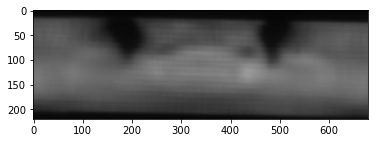

In [14]:
from matplotlib import pyplot as plt
plt.imshow(img)

In [22]:
img2 = random_crop(img, 190, 660)
img2.shape

(190, 660, 3)

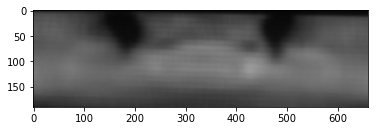

In [21]:
plt.imshow(img2)

## Model

In [760]:
resnet = models.resnet34(pretrained=True)

In [605]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.out = 2*512 + 8
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm2d(self.out, eps=1e-05, momentum=0.1, affine=True)
        self.fc1 = nn.Linear(self.out, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        img, x = x
        img = F.relu(self.top_model(img))
        img1 = nn.AdaptiveMaxPool2d((1,1))(img)
        img2 = nn.AdaptiveAvgPool2d((1,1))(img)
        img1 = img1.view(img1.shape[0], -1)
        img2 = img2.view(img2.shape[0], -1)
        x = torch.cat([img1, img2, x.float()], 1)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.3)(x)
        x = F.relu(self.fc2(x))
        return x

## Testing model

In [606]:
net = Net().cuda()

In [607]:
x, y = next(iter(train_loader))

In [608]:
img, x = x

In [609]:
x = Variable(x).cuda()
img = Variable(img).cuda()

In [610]:
xx = img, x
pred = net(xx)

In [611]:
pred.shape

torch.Size([64, 1])

## Unfreeze

In [534]:
# from fast.ai
def set_trainable_attr(m, b=True):
    m.trainable = b
    for p in m.parameters(): p.requires_grad = b

In [535]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

## Training

In [536]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable, change shape of the input
            img, x = images
            batch = x.shape[0]
            x = Variable(x).cuda()
            img = Variable(img).cuda()
            labels = Variable(labels).cuda().float()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            xx = img, x
            outputs = model(xx).float()
            loss = F.l1_loss(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_loss = model_loss(model, test_loader)
        print('Epoch [%d/%d], Valid MAE: %.4f' %(epoch+1, num_epochs, val_loss))
    return val_loss, train_loss

In [537]:
def model_loss(model, test_loader):
    model.eval()
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        img, x = images
        x = Variable(x).cuda()
        img = Variable(img).cuda()
        labels = Variable(labels).cuda().float()
        xx = img, x
        outputs = model(xx)
        loss = F.l1_loss(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
    return sum_loss/ total

In [612]:
net = Net().cuda()

In [613]:
learning_rate = 0.01
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)

In [614]:
train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)

Epoch [1/10], Loss: 1.1426
Epoch [1/10], Valid MAE: 1.4467
Epoch [2/10], Loss: 1.0139
Epoch [2/10], Valid MAE: 1.3815
Epoch [3/10], Loss: 0.9389
Epoch [3/10], Valid MAE: 1.4243
Epoch [4/10], Loss: 0.9284
Epoch [4/10], Valid MAE: 1.3204
Epoch [5/10], Loss: 0.9003
Epoch [5/10], Valid MAE: 1.2670
Epoch [6/10], Loss: 0.9044
Epoch [6/10], Valid MAE: 1.2557
Epoch [7/10], Loss: 0.8806
Epoch [7/10], Valid MAE: 1.1735
Epoch [8/10], Loss: 0.8530
Epoch [8/10], Valid MAE: 1.2040
Epoch [9/10], Loss: 0.8304
Epoch [9/10], Valid MAE: 1.2275
Epoch [10/10], Loss: 0.8391
Epoch [10/10], Valid MAE: 1.1768


(1.1768416026059318, 0.8391223556539985)

In [615]:
learning_rate = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)

In [616]:
train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)

Epoch [1/10], Loss: 0.8592
Epoch [1/10], Valid MAE: 1.1557
Epoch [2/10], Loss: 0.8181
Epoch [2/10], Valid MAE: 1.1688
Epoch [3/10], Loss: 0.7758
Epoch [3/10], Valid MAE: 1.1617
Epoch [4/10], Loss: 0.8347
Epoch [4/10], Valid MAE: 1.0977
Epoch [5/10], Loss: 0.7908
Epoch [5/10], Valid MAE: 1.0498
Epoch [6/10], Loss: 0.7906
Epoch [6/10], Valid MAE: 1.0436
Epoch [7/10], Loss: 0.7615
Epoch [7/10], Valid MAE: 1.1349
Epoch [8/10], Loss: 0.7869
Epoch [8/10], Valid MAE: 1.0154
Epoch [9/10], Loss: 0.7863
Epoch [9/10], Valid MAE: 1.1254
Epoch [10/10], Loss: 0.8106
Epoch [10/10], Valid MAE: 1.0653


(1.0653140334522022, 0.810619031445364)

In [617]:
learning_rate = 0.0001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)

In [618]:
train_model(train_loader, valid_loader, num_epochs=20, model=net, optimizer=optimizer)

Epoch [1/20], Loss: 0.7639
Epoch [1/20], Valid MAE: 1.0333
Epoch [2/20], Loss: 0.7830
Epoch [2/20], Valid MAE: 1.0432
Epoch [3/20], Loss: 0.7787
Epoch [3/20], Valid MAE: 1.0595
Epoch [4/20], Loss: 0.7950
Epoch [4/20], Valid MAE: 1.0766
Epoch [5/20], Loss: 0.7874
Epoch [5/20], Valid MAE: 1.0385
Epoch [6/20], Loss: 0.8116
Epoch [6/20], Valid MAE: 1.0529
Epoch [7/20], Loss: 0.7709
Epoch [7/20], Valid MAE: 1.0325
Epoch [8/20], Loss: 0.7821
Epoch [8/20], Valid MAE: 1.0386
Epoch [9/20], Loss: 0.8005
Epoch [9/20], Valid MAE: 1.0353
Epoch [10/20], Loss: 0.8031
Epoch [10/20], Valid MAE: 1.0923
Epoch [11/20], Loss: 0.8058
Epoch [11/20], Valid MAE: 1.1141
Epoch [12/20], Loss: 0.7557
Epoch [12/20], Valid MAE: 1.1065
Epoch [13/20], Loss: 0.7484
Epoch [13/20], Valid MAE: 1.0985
Epoch [14/20], Loss: 0.7916
Epoch [14/20], Valid MAE: 1.1346
Epoch [15/20], Loss: 0.7944
Epoch [15/20], Valid MAE: 1.0824
Epoch [16/20], Loss: 0.7806
Epoch [16/20], Valid MAE: 1.0665
Epoch [17/20], Loss: 0.7860
Epoch [17/20],

(1.0633799679139082, 0.8279487082127774)

In [619]:
# unfreezing the last convolutional layer
unfreeze(net, 7)

In [620]:
learning_rate = 0.00001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)

In [621]:
train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)

Epoch [1/10], Loss: 0.7721
Epoch [1/10], Valid MAE: 1.0790
Epoch [2/10], Loss: 0.7770
Epoch [2/10], Valid MAE: 1.0698
Epoch [3/10], Loss: 0.7367
Epoch [3/10], Valid MAE: 1.0093
Epoch [4/10], Loss: 0.7665
Epoch [4/10], Valid MAE: 1.0240
Epoch [5/10], Loss: 0.7364
Epoch [5/10], Valid MAE: 1.0093
Epoch [6/10], Loss: 0.7499
Epoch [6/10], Valid MAE: 1.0929
Epoch [7/10], Loss: 0.7512
Epoch [7/10], Valid MAE: 1.0384
Epoch [8/10], Loss: 0.7896
Epoch [8/10], Valid MAE: 1.0704
Epoch [9/10], Loss: 0.7592
Epoch [9/10], Valid MAE: 1.0620
Epoch [10/10], Loss: 0.7033
Epoch [10/10], Valid MAE: 1.0148


(1.0147762228460873, 0.7033119328906027)

## Train Fold

In [709]:
def train_fold(k):
    imrt_train = IMRTQADataset(path="/data2/yinterian/IMRT-2/", csv_file=f"imrt-train-{k}.csv")
    imrt_valid = IMRTQADataset(path="/data2/yinterian/IMRT-2/", csv_file=f"imrt-val-{k}.csv")
    train_loader = DataLoader(imrt_train, batch_size=64, shuffle=True)
    valid_loader = DataLoader(imrt_valid, batch_size=64, shuffle=False)
    net = Net().cuda()
    learning_rate = 0.01
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)
    train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)
    learning_rate = 0.001
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)
    train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)
    learning_rate = 0.0001
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)
    train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)
    unfreeze(net, 7)
    learning_rate = 0.00001
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate)
    train_model(train_loader, valid_loader, num_epochs=10, model=net, optimizer=optimizer)
    return net, valid_loader

## Predict

In [622]:
def predict(model, valid_loader):
    model.eval()
    sum_loss = 0.0
    total = 0
    y = []
    pred = []
    for images, labels in valid_loader:
        img, x = images
        batch = x.shape[0]
        x = Variable(x).cuda()
        img = Variable(img).cuda()
        labels = Variable(labels).cuda().float()
        
        xx = img, x
        outputs = model(xx).float()
        loss = F.l1_loss(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        y.append(labels.data.cpu().numpy())
        pred.append(outputs.data.cpu().numpy())
    return np.concatenate(y), np.concatenate(pred)

In [ ]:
def get_predictions(net, valid_loader):
    y, pred = predict(net, valid_loader)
    pp = pred.reshape(-1)
    res = pd.DataFrame({'pred':pp, 'y':y})
    return res

In [723]:
for k in range(1,11):
    print(k)
    net, valid_loader = train_fold(k)
    res = get_predictions(net, valid_loader)
    res.to_csv(f"{path}/res-{k}.csv", index=False)

1
Epoch [1/10], Loss: 1.1374
Epoch [1/10], Valid MAE: 1.0750
Epoch [2/10], Loss: 0.9819
Epoch [2/10], Valid MAE: 1.0188
Epoch [3/10], Loss: 0.9783
Epoch [3/10], Valid MAE: 1.0922
Epoch [4/10], Loss: 0.9087
Epoch [4/10], Valid MAE: 1.0145
Epoch [5/10], Loss: 0.9016
Epoch [5/10], Valid MAE: 1.0173
Epoch [6/10], Loss: 0.9063
Epoch [6/10], Valid MAE: 1.1290
Epoch [7/10], Loss: 0.8303
Epoch [7/10], Valid MAE: 1.0029
Epoch [8/10], Loss: 0.8573
Epoch [8/10], Valid MAE: 0.9146
Epoch [9/10], Loss: 0.8227
Epoch [9/10], Valid MAE: 0.8944
Epoch [10/10], Loss: 0.8606
Epoch [10/10], Valid MAE: 0.8653
Epoch [1/10], Loss: 0.8207
Epoch [1/10], Valid MAE: 0.9345
Epoch [2/10], Loss: 0.7621
Epoch [2/10], Valid MAE: 1.0254
Epoch [3/10], Loss: 0.7842
Epoch [3/10], Valid MAE: 0.9541
Epoch [4/10], Loss: 0.8079
Epoch [4/10], Valid MAE: 0.9000
Epoch [5/10], Loss: 0.8225
Epoch [5/10], Valid MAE: 0.8598
Epoch [6/10], Loss: 0.7774
Epoch [6/10], Valid MAE: 0.7763
Epoch [7/10], Loss: 0.8183
Epoch [7/10], Valid MAE: 

Epoch [9/10], Valid MAE: 1.0004
Epoch [10/10], Loss: 0.8138
Epoch [10/10], Valid MAE: 0.9730
Epoch [1/10], Loss: 0.7890
Epoch [1/10], Valid MAE: 0.9737
Epoch [2/10], Loss: 0.8159
Epoch [2/10], Valid MAE: 0.9055
Epoch [3/10], Loss: 0.8062
Epoch [3/10], Valid MAE: 1.0603
Epoch [4/10], Loss: 0.8234
Epoch [4/10], Valid MAE: 1.0493
Epoch [5/10], Loss: 0.7902
Epoch [5/10], Valid MAE: 0.9395
Epoch [6/10], Loss: 0.7846
Epoch [6/10], Valid MAE: 0.9298
Epoch [7/10], Loss: 0.8076
Epoch [7/10], Valid MAE: 0.9326
Epoch [8/10], Loss: 0.7753
Epoch [8/10], Valid MAE: 0.8923
Epoch [9/10], Loss: 0.8063
Epoch [9/10], Valid MAE: 0.9106
Epoch [10/10], Loss: 0.7810
Epoch [10/10], Valid MAE: 1.0359
Epoch [1/10], Loss: 0.7866
Epoch [1/10], Valid MAE: 0.9941
Epoch [2/10], Loss: 0.7932
Epoch [2/10], Valid MAE: 0.9036
Epoch [3/10], Loss: 0.7730
Epoch [3/10], Valid MAE: 0.9191
Epoch [4/10], Loss: 0.7772
Epoch [4/10], Valid MAE: 1.0250
Epoch [5/10], Loss: 0.7695
Epoch [5/10], Valid MAE: 1.0947
Epoch [6/10], Loss: 

Epoch [8/10], Loss: 0.7228
Epoch [8/10], Valid MAE: 1.1330
Epoch [9/10], Loss: 0.7082
Epoch [9/10], Valid MAE: 1.1265
Epoch [10/10], Loss: 0.7040
Epoch [10/10], Valid MAE: 1.1271
8
Epoch [1/10], Loss: 1.0227
Epoch [1/10], Valid MAE: 1.4206
Epoch [2/10], Loss: 0.9491
Epoch [2/10], Valid MAE: 1.3557
Epoch [3/10], Loss: 0.9601
Epoch [3/10], Valid MAE: 1.3974
Epoch [4/10], Loss: 0.9254
Epoch [4/10], Valid MAE: 1.2541
Epoch [5/10], Loss: 0.8988
Epoch [5/10], Valid MAE: 1.2090
Epoch [6/10], Loss: 0.8399
Epoch [6/10], Valid MAE: 1.3523
Epoch [7/10], Loss: 0.8157
Epoch [7/10], Valid MAE: 1.3570
Epoch [8/10], Loss: 0.8030
Epoch [8/10], Valid MAE: 1.2722
Epoch [9/10], Loss: 0.8055
Epoch [9/10], Valid MAE: 1.3058
Epoch [10/10], Loss: 0.7876
Epoch [10/10], Valid MAE: 1.2047
Epoch [1/10], Loss: 0.7753
Epoch [1/10], Valid MAE: 1.1859
Epoch [2/10], Loss: 0.7963
Epoch [2/10], Valid MAE: 1.1920
Epoch [3/10], Loss: 0.7643
Epoch [3/10], Valid MAE: 1.1524
Epoch [4/10], Loss: 0.7757
Epoch [4/10], Valid MAE

In [743]:
df = pd.concat([pd.read_csv(f"{path}/res-{k}.csv") for k in range(11)])

In [739]:
df.to_csv(f"{path}/results-10-fold-cross.csv", index=False)

In [729]:
## write current error here
error = np.abs(df["y"] - df["pred"]).mean()
error 

0.9402008771857149

In [730]:
m = np.median(df["y"].values)
m

0.69999998807907104

In [731]:
r =  df["y"].values - m
res_mean = np.abs(r).mean()
res_mean

1.1087578904903248

In [732]:
1- error/res_mean

0.15202328186369807

In [733]:
df["residual"] = df["y"] - df["pred"]

In [735]:
errors3 = np.abs(df["residual"].values) > 3

In [736]:
errors3.sum()

30

In [737]:
r.shape

(475,)

In [738]:
1- 30/475

0.9368421052631579

In [740]:
df_val = pd.concat([pd.read_csv(f"{path}/imrt-val-{k}.csv") for k in range(11)])

In [742]:
df_val.head()

,Technique,NumberOfFields,NumberOfDetectors,SBRTplan,GlobalPassingRate,id,Energy_1,Energy_2,Energy_3,Energy_4,Machine-Type_1,Machine-Type_2,Machine-Type_3,Machine-Type_5
0,1,2,601.0,0.0,100.0,64,0,0,1,0,1,0,0,0
1,1,2,465.0,0.0,99.6,641,1,0,0,0,0,1,0,0
2,1,2,300.0,1.0,96.3,478,0,0,1,0,1,0,0,0
3,1,2,394.0,1.0,94.4,743,0,1,0,0,0,1,0,0
4,1,2,607.0,0.0,100.0,336,1,0,0,0,0,0,0,1


In [744]:
df.head()

,pred,y
0,0.000000,0.0
1,0.371368,0.4
2,1.355743,3.7
3,1.084216,5.6
4,0.112647,0.0


In [746]:
df_2 = pd.concat([df, df_val], axis=1)

In [749]:
diff = 100 - df_2["y"] - df_2["GlobalPassingRate"]

In [753]:
df_2.head()

,pred,y,Technique,NumberOfFields,NumberOfDetectors,SBRTplan,GlobalPassingRate,id,Energy_1,Energy_2,Energy_3,Energy_4,Machine-Type_1,Machine-Type_2,Machine-Type_3,Machine-Type_5,residual
0,0.000000,0.0,1,2,601.0,0.0,100.0,64,0,0,1,0,1,0,0,0,0.000000
1,0.371368,0.4,1,2,465.0,0.0,99.6,641,1,0,0,0,0,1,0,0,0.028632
2,1.355743,3.7,1,2,300.0,1.0,96.3,478,0,0,1,0,1,0,0,0,2.344257
3,1.084216,5.6,1,2,394.0,1.0,94.4,743,0,1,0,0,0,1,0,0,4.515784
4,0.112647,0.0,1,2,607.0,0.0,100.0,336,1,0,0,0,0,0,0,1,-0.112647


In [752]:
df_2["residual"] = df_2["y"] - df_2["pred"]

In [755]:
outliers = df_2.loc[np.abs(df_2["residual"]) > 3]

In [756]:
outliers.shape

(30, 17)

In [758]:
outliers["id"].values

array([743, 105, 117, 131, 130, 706, 380, 308, 666, 606, 481, 696, 627,
       165, 748, 709, 523, 682, 399, 392, 400, 703,  31, 452, 574, 494,
       660, 618, 320, 622])

In [759]:
outliers.to_csv(f"{path}/outliers.csv", index=False)